In [5]:
import json
import numpy as np
import pandas as pd

In [6]:
# Load your merged JSONs
def load_merged_skeletons(json_path, person_id):
    """
    Load merged skeleton json for a single person.
    Each record is one frame with keys:
        face_keypoints_2d, hand_left_keypoints_2d, 
        hand_right_keypoints_2d, pose_keypoints_2d
    """
    with open(json_path, "r") as f:
        data = json.load(f)

    all_frames, all_skeletons = [], []

    for frame_idx, frame_data in enumerate(data):
        # We only use pose_keypoints_2d for body analysis
        skeleton = np.array(frame_data["pose_keypoints_2d"], dtype=np.float32)
        all_frames.append(frame_idx)
        all_skeletons.append(skeleton)

    df = pd.DataFrame({
        "frame": all_frames,
        "id_name": person_id,
        "skeleton": all_skeletons
    })
    return df


In [7]:
df1 = load_merged_skeletons("/home/liubov/Desktop/BNF/work/8-5-2024_#18_INDIVIDUAL_[12]/PosesDir/new_jsons_merged_id_1.json", "Patient1")
df2 = load_merged_skeletons("/home/liubov/Desktop/BNF/work/8-5-2024_#18_INDIVIDUAL_[12]/PosesDir/new_jsons_merged_id_2.json", "Patient2")
df3 = load_merged_skeletons("/home/liubov/Desktop/BNF/work/8-5-2024_#18_INDIVIDUAL_[12]/PosesDir/new_jsons_merged_id_3.json", "Patient3")

skeleton_dataset = pd.concat([df1, df2, df3], ignore_index=True)


In [8]:
skeleton_dataset

,frame,id_name,skeleton
0,0,Patient1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,Patient1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,Patient1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,Patient1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,Patient1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
35350,11780,Patient3,"[530.94147, 176.916, 0.997454, 529.7954, 170.8..."
35351,11781,Patient3,"[530.1583, 176.3932, 0.9976535, 529.2131, 170...."
35352,11782,Patient3,"[530.13727, 177.43954, 0.9976541, 529.0115, 17..."
35353,11783,Patient3,"[530.2371, 177.42245, 0.9976567, 528.9901, 171..."


In [9]:
# Extract joints (like notebook function)
JOINT_NAMES = {
    0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
    5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "MidHip",
    9: "RHip", 10: "RKnee", 11: "RAnkle", 12: "LHip",
    13: "LKnee", 14: "LAnkle", 15: "REye", 16: "LEye",
    17: "REar", 18: "LEar", 19: "LBigToe", 20: "LSmallToe",
    21: "LHeel", 22: "RBigToe", 23: "RSmallToe", 24: "RHeel",
    25: "Background"
}

def extract_joint_positions(skeleton_dataset, person_id, joint_idx=0, confidence_threshold=0.5):
    joint_name = JOINT_NAMES.get(joint_idx, f"Joint_{joint_idx}")
    person_data = skeleton_dataset[skeleton_dataset["id_name"] == person_id].copy()

    frames = person_data["frame"].values
    positions = {}

    for frame, skeleton in zip(frames, person_data["skeleton"].values):
        if skeleton is None or len(skeleton) < (joint_idx*3+3):
            continue
        x, y, conf = skeleton[joint_idx*3: joint_idx*3+3]
        if conf >= confidence_threshold:
            positions[frame] = (x, y)

    return positions, joint_name


In [10]:
# Compute variance of movement
positions, joint_name = extract_joint_positions(skeleton_dataset, "Patient1", joint_idx=4)  # RWrist
if positions:
    coords = np.array(list(positions.values()))
    movement_var = np.var(coords, axis=0)  # [var_x, var_y]
    print(f"{joint_name} movement variance for Patient1:", movement_var)


RWrist movement variance for Patient1: [18812.395   5889.0264]


In [11]:
# Visualize movement paths
import matplotlib.pyplot as plt

def plot_joint_trajectory(positions, joint_name, person_id):
    coords = np.array(list(positions.values()))
    plt.plot(coords[:,0], coords[:,1], marker="o", markersize=1, linewidth=0.5)
    plt.gca().invert_yaxis()  # Flip y for image coordinates
    plt.title(f"{person_id} - {joint_name} Trajectory")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


/home/liubov/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


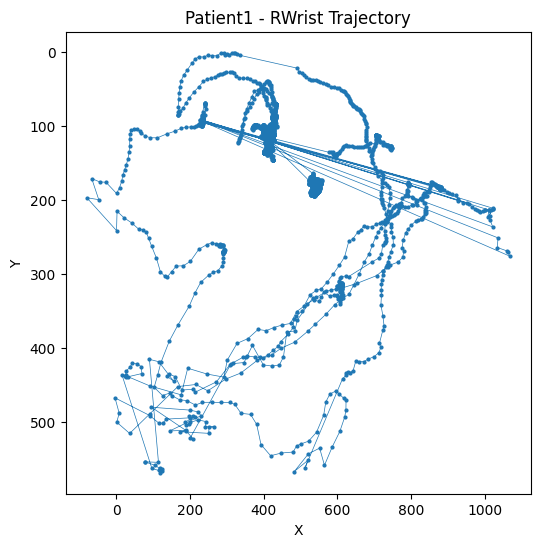

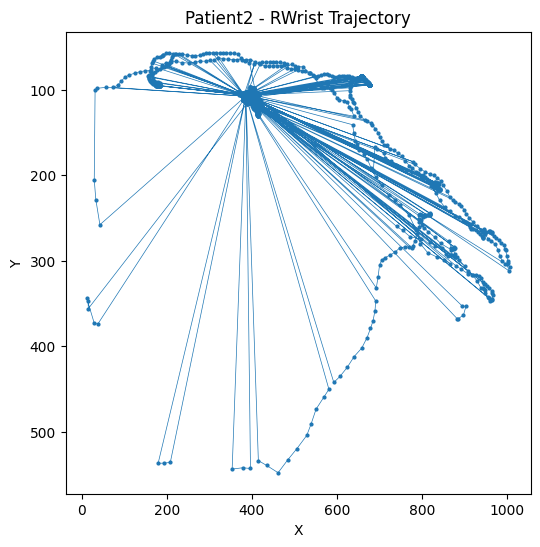

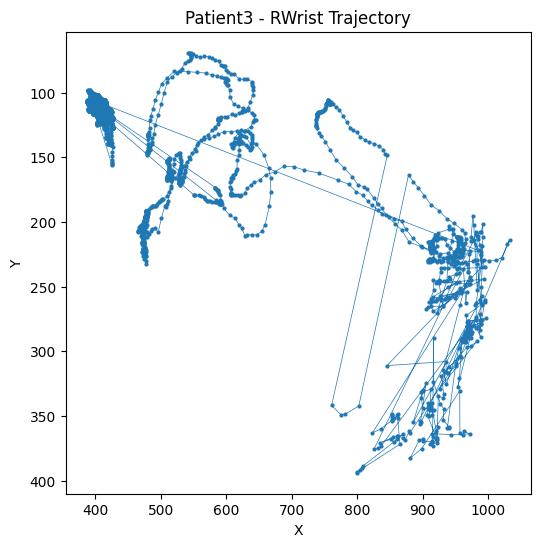

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the frame-level positions instead of variance
df = pd.read_csv("joint_positions.csv")

def plot_joint_from_csv(df, patient, joint):
    """Plot trajectory (dots connected with line) for a given patient & joint."""
    subset = df[(df["Patient"] == patient) & (df["Joint"] == joint)]
    if subset.empty:
        print(f"No data found for {patient} - {joint}")
        return
    
    plt.figure(figsize=(6, 6))
    plt.plot(subset["X"], subset["Y"], marker="o", markersize=2, linewidth=0.5)
    plt.gca().invert_yaxis()  # Match image coordinates
    plt.title(f"{patient} - {joint} Trajectory")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

# === Plot RWrist trajectory for all patients ===
for patient in df["Patient"].unique():
    plot_joint_from_csv(df, patient, "RWrist")


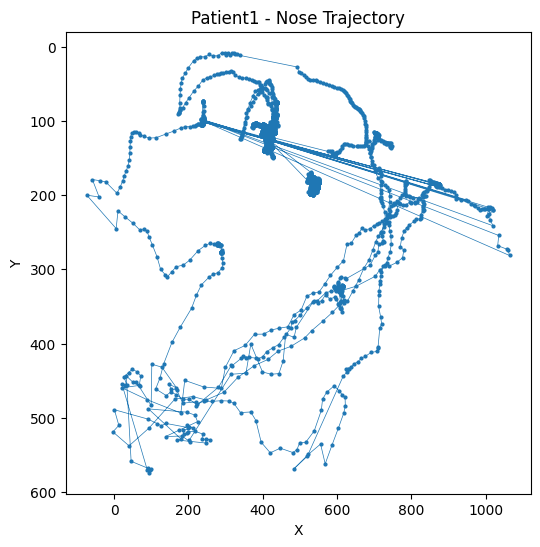

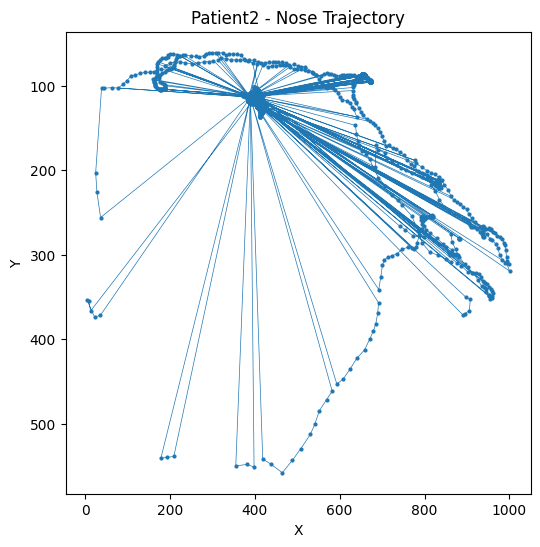

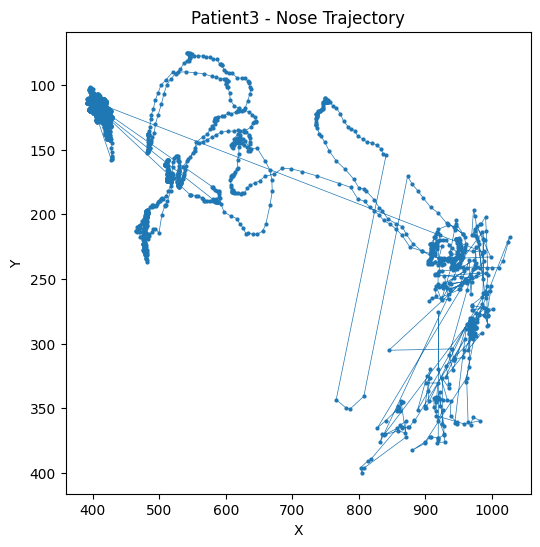

In [25]:
for patient in df["Patient"].unique():
    plot_joint_from_csv(df, patient, "Nose")

In [26]:
# # Detect repetitive sequences in the trajectory
# def detect_repetitive_patterns(x, y, window_size=10, threshold=0.1):
#     # Look for similar movement subsequences
#     patterns = []
#     for i in range(len(x) - window_size):
#         current_window = np.column_stack([x[i:i+window_size], y[i:i+window_size]])
#         # Compare with other windows to find repetitions
#     return patterns

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from scipy.fft import fft, fftfreq
import seaborn as sns
from typing import Dict, List, Tuple, Optional

# ============================================================================
# STEP 1: DATA PREPARATION AND EXTRACTION
# ============================================================================

def step1_extract_patient_data(df: pd.DataFrame, patient: str, joint: str = 'Nose'):
    """
    STEP 1: Extract trajectory data for a specific patient and joint
    
    Args:
        df: Your DataFrame with columns ['Patient', 'Joint', 'Frame', 'X', 'Y']
        patient: Patient ID (e.g., 'Patient1', 'Patient3')
        joint: Joint name (default: 'Nose')
    
    Returns:
        frames, x_coords, y_coords, duration_info
    """
    print(f"📊 STEP 1: Extracting data for {patient} - {joint}")
    
    # Filter data for specific patient and joint
    patient_data = df[(df['Patient'] == patient) & (df['Joint'] == joint)].copy()
    patient_data = patient_data.sort_values('Frame')
    
    # Extract coordinates
    frames = patient_data['Frame'].values
    x_coords = patient_data['X'].values
    y_coords = patient_data['Y'].values
    
    # Basic info
    total_frames = len(frames)
    frame_range = frames[-1] - frames[0] if len(frames) > 1 else 0
    
    print(f"   ✅ Found {total_frames} data points")
    print(f"   ✅ Frame range: {frames[0]} to {frames[-1]} (span: {frame_range})")
    print(f"   ✅ X range: {x_coords.min():.2f} to {x_coords.max():.2f}")
    print(f"   ✅ Y range: {y_coords.min():.2f} to {y_coords.max():.2f}")
    
    duration_info = {
        'total_frames': total_frames,
        'frame_range': frame_range,
        'x_range': (x_coords.min(), x_coords.max()),
        'y_range': (y_coords.min(), y_coords.max())
    }
    
    return frames, x_coords, y_coords, duration_info

# ============================================================================
# STEP 2: BASIC MOVEMENT CALCULATIONS
# ============================================================================

def step2_calculate_basic_movement(x_coords: np.ndarray, y_coords: np.ndarray, fps: float = 30.0):
    """
    STEP 2: Calculate basic movement metrics (speed, acceleration, jerk)
    
    Args:
        x_coords, y_coords: Position coordinates
        fps: Frames per second
    
    Returns:
        movement_data dictionary with speed, acceleration, jerk, and basic stats
    """
    print(f"\n🔢 STEP 2: Calculating basic movement metrics")
    
    if len(x_coords) < 3:
        print("   ❌ Error: Need at least 3 data points")
        return None
    
    dt = 1.0 / fps  # Time step
    
    # Calculate derivatives
    # Velocity (pixels per second)
    vx = np.gradient(x_coords) / dt
    vy = np.gradient(y_coords) / dt
    speed = np.sqrt(vx**2 + vy**2)
    
    # Acceleration (pixels per second²)
    ax = np.gradient(vx) / dt
    ay = np.gradient(vy) / dt
    acceleration = np.sqrt(ax**2 + ay**2)
    
    # Jerk (pixels per second³) - indicates smoothness
    jx = np.gradient(ax) / dt
    jy = np.gradient(ay) / dt
    jerk = np.sqrt(jx**2 + jy**2)
    
    # Basic statistics
    movement_data = {
        'speed': speed,
        'acceleration': acceleration,
        'jerk': jerk,
        'mean_speed': np.mean(speed),
        'max_speed': np.max(speed),
        'speed_std': np.std(speed),
        'mean_acceleration': np.mean(acceleration),
        'mean_jerk': np.mean(jerk),
        'smoothness_score': 1.0 / (1.0 + np.mean(jerk))  # Higher = smoother
    }
    
    print(f"   ✅ Mean speed: {movement_data['mean_speed']:.2f} pixels/second")
    print(f"   ✅ Max speed: {movement_data['max_speed']:.2f} pixels/second")
    print(f"   ✅ Speed variability (std): {movement_data['speed_std']:.2f}")
    print(f"   ✅ Smoothness score: {movement_data['smoothness_score']:.3f} (higher = smoother)")
    
    return movement_data

# ============================================================================
# STEP 3: DETECT REPETITIVE PATTERNS (STEREOTYPIES)
# ============================================================================

def step3_detect_repetitive_patterns(x_coords: np.ndarray, y_coords: np.ndarray, 
                                   window_size: int = 20, similarity_threshold: float = 0.7):
    """
    STEP 3: Detect repetitive movement patterns that might indicate stereotyped behavior
    
    Args:
        x_coords, y_coords: Position coordinates
        window_size: Size of pattern window to compare
        similarity_threshold: Correlation threshold for pattern matching
    
    Returns:
        Dictionary with pattern information
    """
    print(f"\n🔄 STEP 3: Detecting repetitive patterns (stereotypies)")
    print(f"   Using window size: {window_size}, similarity threshold: {similarity_threshold}")
    
    patterns = []
    n = len(x_coords)
    
    if n < window_size * 2:
        print(f"   ❌ Warning: Need at least {window_size * 2} data points, got {n}")
        return {'pattern_count': 0, 'patterns': [], 'regularity_score': 0.0}
    
    # Sliding window approach to find similar patterns
    pattern_count = 0
    
    for i in range(n - window_size):
        # Current pattern window
        curr_x = x_coords[i:i+window_size]
        curr_y = y_coords[i:i+window_size]
        
        # Normalize to starting position
        curr_x_norm = curr_x - curr_x[0]
        curr_y_norm = curr_y - curr_y[0]
        
        # Look for similar patterns later in the sequence
        for j in range(i + window_size, n - window_size):
            comp_x = x_coords[j:j+window_size]
            comp_y = y_coords[j:j+window_size]
            
            # Normalize comparison pattern
            comp_x_norm = comp_x - comp_x[0]
            comp_y_norm = comp_y - comp_y[0]
            
            # Calculate correlation similarity
            try:
                if np.std(curr_x_norm) > 1e-10 and np.std(comp_x_norm) > 1e-10:
                    corr_x = np.corrcoef(curr_x_norm, comp_x_norm)[0,1]
                else:
                    corr_x = 0
                
                if np.std(curr_y_norm) > 1e-10 and np.std(comp_y_norm) > 1e-10:
                    corr_y = np.corrcoef(curr_y_norm, comp_y_norm)[0,1]
                else:
                    corr_y = 0
                
                avg_similarity = (corr_x + corr_y) / 2
                
                if not np.isnan(avg_similarity) and avg_similarity > similarity_threshold:
                    patterns.append({
                        'pattern1_start': i,
                        'pattern1_end': i + window_size,
                        'pattern2_start': j,
                        'pattern2_end': j + window_size,
                        'similarity': avg_similarity
                    })
                    pattern_count += 1
                    
            except Exception as e:
                continue
    
    # Calculate regularity score
    regularity_score = pattern_count / max(1, (n - window_size))
    
    repetitive_data = {
        'pattern_count': pattern_count,
        'patterns': patterns,
        'regularity_score': regularity_score
    }
    
    print(f"   ✅ Found {pattern_count} repetitive patterns")
    print(f"   ✅ Regularity score: {regularity_score:.3f} (higher = more repetitive)")
    
    # Interpretation
    if regularity_score > 0.1:
        print(f"   🚨 HIGH repetitiveness detected - possible stereotyped behavior")
    elif regularity_score > 0.05:
        print(f"   ⚠️  MODERATE repetitiveness detected")
    else:
        print(f"   ✅ LOW repetitiveness - varied movement patterns")
    
    return repetitive_data

# ============================================================================
# STEP 4: DETECT FREEZING EPISODES
# ============================================================================

def step4_detect_freezing_episodes(x_coords: np.ndarray, y_coords: np.ndarray, 
                                 fps: float = 30.0, stillness_percentile: float = 10, 
                                 min_duration: float = 1.0):
    """
    STEP 4: Detect periods of minimal movement (freezing/stillness episodes)
    
    Args:
        x_coords, y_coords: Position coordinates
        fps: Frames per second
        stillness_percentile: Percentile threshold for defining "still"
        min_duration: Minimum duration (seconds) to count as freeze episode
    
    Returns:
        Dictionary with freezing episode information
    """
    print(f"\n🧊 STEP 4: Detecting freezing episodes")
    print(f"   Stillness threshold: {stillness_percentile}th percentile")
    print(f"   Minimum freeze duration: {min_duration} seconds")
    
    # Calculate instantaneous movement
    movement_distances = np.sqrt(np.diff(x_coords)**2 + np.diff(y_coords)**2)
    
    # Define stillness threshold
    stillness_threshold = np.percentile(movement_distances, stillness_percentile)
    still_mask = movement_distances < stillness_threshold
    
    print(f"   Stillness threshold: {stillness_threshold:.2f} pixels per frame")
    
    # Find continuous still periods
    episodes = []
    min_frames = int(min_duration * fps)
    
    in_episode = False
    episode_start = 0
    
    for i, is_still in enumerate(still_mask):
        if is_still and not in_episode:
            episode_start = i
            in_episode = True
        elif not is_still and in_episode:
            episode_length = i - episode_start
            if episode_length >= min_frames:
                episodes.append({
                    'start_frame': episode_start,
                    'end_frame': i,
                    'duration_seconds': episode_length / fps,
                    'duration_frames': episode_length
                })
            in_episode = False
    
    # Handle episode continuing to end
    if in_episode:
        episode_length = len(still_mask) - episode_start
        if episode_length >= min_frames:
            episodes.append({
                'start_frame': episode_start,
                'end_frame': len(still_mask),
                'duration_seconds': episode_length / fps,
                'duration_frames': episode_length
            })
    
    # Calculate summary statistics
    total_freeze_time = sum([ep['duration_seconds'] for ep in episodes])
    total_duration = len(x_coords) / fps
    freeze_percentage = (total_freeze_time / total_duration) * 100
    
    freezing_data = {
        'episodes': episodes,
        'episode_count': len(episodes),
        'total_freeze_time': total_freeze_time,
        'freeze_percentage': freeze_percentage,
        'threshold_used': stillness_threshold
    }
    
    print(f"   ✅ Found {len(episodes)} freezing episodes")
    print(f"   ✅ Total freeze time: {total_freeze_time:.1f} seconds")
    print(f"   ✅ Freeze percentage: {freeze_percentage:.1f}% of total time")
    
    # Interpretation
    if freeze_percentage > 30:
        print(f"   🚨 HIGH freeze percentage - possible regulation difficulties")
    elif freeze_percentage > 15:
        print(f"   ⚠️  MODERATE freeze percentage")
    else:
        print(f"   ✅ LOW freeze percentage - active movement pattern")
    
    return freezing_data

# ============================================================================
# STEP 5: FREQUENCY ANALYSIS (RHYTHMIC PATTERNS)
# ============================================================================

def step5_analyze_frequency_patterns(x_coords: np.ndarray, y_coords: np.ndarray, fps: float = 30.0):
    """
    STEP 5: Analyze frequency content to detect rhythmic movement patterns
    
    Args:
        x_coords, y_coords: Position coordinates
        fps: Frames per second
    
    Returns:
        Dictionary with frequency analysis results
    """
    print(f"\n📊 STEP 5: Analyzing frequency patterns (rhythmic behaviors)")
    
    if len(x_coords) < 10:
        print("   ❌ Error: Need at least 10 data points for frequency analysis")
        return None
    
    # Create magnitude signal
    magnitude = np.sqrt(x_coords**2 + y_coords**2)
    magnitude = magnitude - np.mean(magnitude)  # Remove DC component
    
    # Apply FFT
    fft_vals = fft(magnitude)
    freqs = fftfreq(len(magnitude), 1/fps)
    
    # Keep only positive frequencies
    pos_mask = freqs > 0
    freqs_pos = freqs[pos_mask]
    fft_power = np.abs(fft_vals[pos_mask])**2
    
    # Find dominant frequency
    if len(fft_power) > 0:
        dominant_idx = np.argmax(fft_power)
        dominant_frequency = freqs_pos[dominant_idx]
        dominant_power = fft_power[dominant_idx]
        
        # Calculate spectral entropy (measure of regularity)
        normalized_power = fft_power / np.sum(fft_power)
        spectral_entropy = -np.sum(normalized_power * np.log2(normalized_power + 1e-10))
        max_entropy = np.log2(len(normalized_power))
        normalized_entropy = spectral_entropy / max_entropy if max_entropy > 0 else 0
        
    else:
        dominant_frequency = 0
        dominant_power = 0
        normalized_entropy = 0
    
    frequency_data = {
        'dominant_frequency': dominant_frequency,
        'dominant_power': dominant_power,
        'spectral_entropy': normalized_entropy,
        'frequency_spectrum': (freqs_pos, fft_power)
    }
    
    print(f"   ✅ Dominant frequency: {dominant_frequency:.2f} Hz")
    print(f"   ✅ Spectral entropy: {normalized_entropy:.3f} (lower = more rhythmic)")
    
    # Interpret frequency
    if dominant_frequency > 2.0:
        print(f"   🚨 HIGH frequency movement detected - possible fidgeting/tremor")
    elif dominant_frequency > 0.5:
        print(f"   ⚠️  MODERATE frequency movement - possible rhythmic behavior")
    elif dominant_frequency > 0.1:
        print(f"   ✅ LOW frequency movement - slow, controlled movements")
    else:
        print(f"   ✅ VERY LOW frequency - minimal rhythmic patterns")
    
    return frequency_data

# ============================================================================
# STEP 6: SPATIAL ANALYSIS
# ============================================================================

def step6_analyze_spatial_patterns(x_coords: np.ndarray, y_coords: np.ndarray):
    """
    STEP 6: Analyze spatial characteristics of movement
    
    Args:
        x_coords, y_coords: Position coordinates
    
    Returns:
        Dictionary with spatial analysis results
    """
    print(f"\n🗺️  STEP 6: Analyzing spatial movement patterns")
    
    # Basic spatial metrics
    x_range = np.max(x_coords) - np.min(x_coords)
    y_range = np.max(y_coords) - np.min(y_coords)
    area_coverage = x_range * y_range
    
    # Path metrics
    path_segments = np.sqrt(np.diff(x_coords)**2 + np.diff(y_coords)**2)
    total_path_length = np.sum(path_segments)
    direct_distance = np.sqrt((x_coords[-1] - x_coords[0])**2 + (y_coords[-1] - y_coords[0])**2)
    
    # Movement efficiency (how direct the path is)
    movement_efficiency = direct_distance / max(total_path_length, 1e-10)
    
    # Center of activity
    center_x = np.mean(x_coords)
    center_y = np.mean(y_coords)
    
    # Distance from center
    distances_from_center = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
    mean_distance_from_center = np.mean(distances_from_center)
    
    spatial_data = {
        'x_range': x_range,
        'y_range': y_range,
        'area_coverage': area_coverage,
        'total_path_length': total_path_length,
        'direct_distance': direct_distance,
        'movement_efficiency': movement_efficiency,
        'center_of_activity': (center_x, center_y),
        'mean_distance_from_center': mean_distance_from_center
    }
    
    print(f"   ✅ Movement area: {x_range:.1f} × {y_range:.1f} pixels")
    print(f"   ✅ Total path length: {total_path_length:.1f} pixels")
    print(f"   ✅ Direct distance: {direct_distance:.1f} pixels")
    print(f"   ✅ Movement efficiency: {movement_efficiency:.3f} (higher = more direct)")
    print(f"   ✅ Activity center: ({center_x:.1f}, {center_y:.1f})")
    
    # Interpretation
    if movement_efficiency < 0.1:
        print(f"   🚨 VERY LOW efficiency - highly wandering/circuitous movement")
    elif movement_efficiency < 0.3:
        print(f"   ⚠️  LOW efficiency - somewhat wandering movement")
    else:
        print(f"   ✅ GOOD efficiency - relatively direct movement")
    
    return spatial_data

# ============================================================================
# STEP 7: VISUALIZATION
# ============================================================================

def step7_create_visualizations(x_coords: np.ndarray, y_coords: np.ndarray, 
                              movement_data: dict, freezing_data: dict, 
                              frequency_data: dict, patient_name: str, fps: float = 30.0):
    """
    STEP 7: Create comprehensive visualizations of the analysis
    """
    print(f"\n📈 STEP 7: Creating visualizations for {patient_name}")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Behavioral Analysis - {patient_name}', fontsize=16)
    
    # 1. Trajectory plot
    axes[0,0].plot(x_coords, y_coords, 'b-', alpha=0.7, linewidth=1)
    axes[0,0].scatter(x_coords[0], y_coords[0], color='green', s=100, label='Start', zorder=5)
    axes[0,0].scatter(x_coords[-1], y_coords[-1], color='red', s=100, label='End', zorder=5)
    axes[0,0].set_xlabel('X Position (pixels)')
    axes[0,0].set_ylabel('Y Position (pixels)')
    axes[0,0].set_title('Movement Trajectory')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Speed over time
    speed = movement_data['speed']
    time_points = np.arange(len(speed)) / fps
    axes[0,1].plot(time_points, speed, 'b-', linewidth=1)
    axes[0,1].axhline(y=np.mean(speed), color='r', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(speed):.1f}')
    axes[0,1].set_xlabel('Time (seconds)')
    axes[0,1].set_ylabel('Speed (pixels/second)')
    axes[0,1].set_title('Movement Speed Over Time')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Frequency spectrum
    if frequency_data and 'frequency_spectrum' in frequency_data:
        freqs, power = frequency_data['frequency_spectrum']
        # Show first quarter of spectrum for clarity
        quarter_idx = len(freqs) // 4
        axes[0,2].semilogy(freqs[:quarter_idx], power[:quarter_idx])
        axes[0,2].axvline(x=frequency_data['dominant_frequency'], color='r', 
                         linestyle='--', alpha=0.7, label=f"Dominant: {frequency_data['dominant_frequency']:.2f} Hz")
        axes[0,2].set_xlabel('Frequency (Hz)')
        axes[0,2].set_ylabel('Power (log scale)')
        axes[0,2].set_title('Frequency Spectrum')
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)
    
    # 4. Movement smoothness (jerk over time)
    jerk = movement_data['jerk']
    axes[1,0].plot(time_points[:len(jerk)], jerk, 'g-', linewidth=1)
    axes[1,0].axhline(y=np.mean(jerk), color='r', linestyle='--', alpha=0.7, 
                     label=f'Mean: {np.mean(jerk):.1f}')
    axes[1,0].set_xlabel('Time (seconds)')
    axes[1,0].set_ylabel('Jerk (pixels/second³)')
    axes[1,0].set_title('Movement Smoothness (lower jerk = smoother)')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Freezing episodes overlay
    axes[1,1].plot(time_points, speed, 'b-', alpha=0.7, label='Speed')
    
    # Highlight freezing episodes
    for episode in freezing_data['episodes']:
        start_time = episode['start_frame'] / fps
        end_time = episode['end_frame'] / fps
        axes[1,1].axvspan(start_time, end_time, alpha=0.3, color='red', label='Freeze' if episode == freezing_data['episodes'][0] else "")
    
    axes[1,1].set_xlabel('Time (seconds)')
    axes[1,1].set_ylabel('Speed (pixels/second)')
    axes[1,1].set_title('Freezing Episodes Highlighted')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Summary metrics text
    metrics_text = f"""
    MOVEMENT SUMMARY:
    • Mean Speed: {movement_data['mean_speed']:.1f} px/s
    • Smoothness: {movement_data['smoothness_score']:.3f}
    • Speed Variability: {movement_data['speed_std']:.1f}
    
    BEHAVIORAL PATTERNS:
    • Freeze Episodes: {freezing_data['episode_count']}
    • Freeze Percentage: {freezing_data['freeze_percentage']:.1f}%
    • Dominant Frequency: {frequency_data['dominant_frequency']:.2f} Hz
    
    INTERPRETATION:
    • Smoothness: {'Good' if movement_data['smoothness_score'] > 0.5 else 'Jerky'}
    • Activity Level: {'High Freeze' if freezing_data['freeze_percentage'] > 20 else 'Normal'}
    • Rhythmicity: {'Rhythmic' if frequency_data['dominant_frequency'] > 0.5 else 'Irregular'}
    """
    
    axes[1,2].text(0.05, 0.95, metrics_text, transform=axes[1,2].transAxes, 
                  fontsize=10, verticalalignment='top', fontfamily='monospace')
    axes[1,2].set_xlim(0, 1)
    axes[1,2].set_ylim(0, 1)
    axes[1,2].axis('off')
    axes[1,2].set_title('Summary Metrics & Interpretation')
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN ANALYSIS FUNCTION - RUN ALL STEPS
# ============================================================================

def run_complete_analysis(df: pd.DataFrame, patient: str, joint: str = 'Nose', fps: float = 30.0):
    """
    Run complete step-by-step behavioral analysis
    
    Args:
        df: Your DataFrame with pose data
        patient: Patient ID to analyze
        joint: Joint to analyze (default: 'Nose')
        fps: Frames per second of recording
    
    Returns:
        Complete analysis results dictionary
    """
    print(f"🎯 STARTING COMPLETE BEHAVIORAL ANALYSIS")
    print(f"Patient: {patient}, Joint: {joint}, FPS: {fps}")
    print("="*60)
    
    # Step 1: Extract data
    frames, x_coords, y_coords, duration_info = step1_extract_patient_data(df, patient, joint)
    
    if len(x_coords) < 10:
        print("❌ ERROR: Insufficient data for analysis")
        return None
    
    # Step 2: Basic movement
    movement_data = step2_calculate_basic_movement(x_coords, y_coords, fps)
    
    # # Step 3: Repetitive patterns
    # repetitive_data = step3_detect_repetitive_patterns(x_coords, y_coords)
    
    # Step 4: Freezing episodes
    freezing_data = step4_detect_freezing_episodes(x_coords, y_coords, fps)
    
    # Step 5: Frequency analysis
    frequency_data = step5_analyze_frequency_patterns(x_coords, y_coords, fps)
    
    # Step 6: Spatial analysis
    spatial_data = step6_analyze_spatial_patterns(x_coords, y_coords)
    
    # Step 7: Visualizations
    step7_create_visualizations(x_coords, y_coords, movement_data, freezing_data, 
                               frequency_data, patient, fps)
    
    # Compile complete results
    complete_results = {
        'patient': patient,
        'joint': joint,
        'duration_info': duration_info,
        'movement_characteristics': movement_data,
        # 'repetitive_patterns': repetitive_data,
        'freezing_episodes': freezing_data,
        'frequency_analysis': frequency_data,
        'spatial_analysis': spatial_data
    }
    
    print("\n" + "="*60)
    print("✅ ANALYSIS COMPLETE!")
    print(f"📊 Results stored for {patient}")
    
    return complete_results



In [ ]:
# # Option 1: Run complete analysis
# results = run_complete_analysis(df, 'Patient3', 'Nose', fps=30)

# # Option 2: Run individual steps
# frames, x, y, info = step1_extract_patient_data(df, 'Patient3', 'Nose')
# movement = step2_calculate_basic_movement(x, y, fps=30)
# patterns = step3_detect_repetitive_patterns(x, y)
# freezing = step4_detect_freezing_episodes(x, y, fps=30)
# frequency = step5_analyze_frequency_patterns(x, y, fps=30)
# spatial = step6_analyze_spatial_patterns(x, y)
# step7_create_visualizations(x, y, movement, freezing, frequency, 'Patient3')

# # Option 3: Compare multiple patients
# patients = ['Patient1', 'Patient2', 'Patient3']
# all_results = {}
# for patient in patients:
#     all_results[patient] = run_complete_analysis(df, patient, 'Nose', fps=30)
# """

In [15]:
frames, x, y, info = step1_extract_patient_data(df, 'Patient2', 'Nose')

📊 STEP 1: Extracting data for Patient2 - Nose
   ✅ Found 3716 data points
   ✅ Frame range: 0 to 11774 (span: 11774)
   ✅ X range: 3.97 to 1000.27
   ✅ Y range: 60.93 to 557.86


In [16]:
movement = step2_calculate_basic_movement(x, y, fps=30)


🔢 STEP 2: Calculating basic movement metrics
   ✅ Mean speed: 307.20 pixels/second
   ✅ Max speed: 9732.23 pixels/second
   ✅ Speed variability (std): 1196.31
   ✅ Smoothness score: 0.000 (higher = smoother)


In [17]:
# patterns = step3_detect_repetitive_patterns(x, y)
freezing = step4_detect_freezing_episodes(x, y, fps=30)


🧊 STEP 4: Detecting freezing episodes
   Stillness threshold: 10th percentile
   Minimum freeze duration: 1.0 seconds
   Stillness threshold: 0.06 pixels per frame
   ✅ Found 0 freezing episodes
   ✅ Total freeze time: 0.0 seconds
   ✅ Freeze percentage: 0.0% of total time
   ✅ LOW freeze percentage - active movement pattern


In [18]:
frequency = step5_analyze_frequency_patterns(x, y, fps=30)


📊 STEP 5: Analyzing frequency patterns (rhythmic behaviors)
   ✅ Dominant frequency: 0.01 Hz
   ✅ Spectral entropy: 0.550 (lower = more rhythmic)
   ✅ VERY LOW frequency - minimal rhythmic patterns


In [19]:
spatial = step6_analyze_spatial_patterns(x, y)


🗺️  STEP 6: Analyzing spatial movement patterns
   ✅ Movement area: 996.3 × 496.9 pixels
   ✅ Total path length: 63468.0 pixels
   ✅ Direct distance: 23.0 pixels
   ✅ Movement efficiency: 0.000 (higher = more direct)
   ✅ Activity center: (446.5, 127.4)
   🚨 VERY LOW efficiency - highly wandering/circuitous movement



📈 STEP 7: Creating visualizations for Patient3


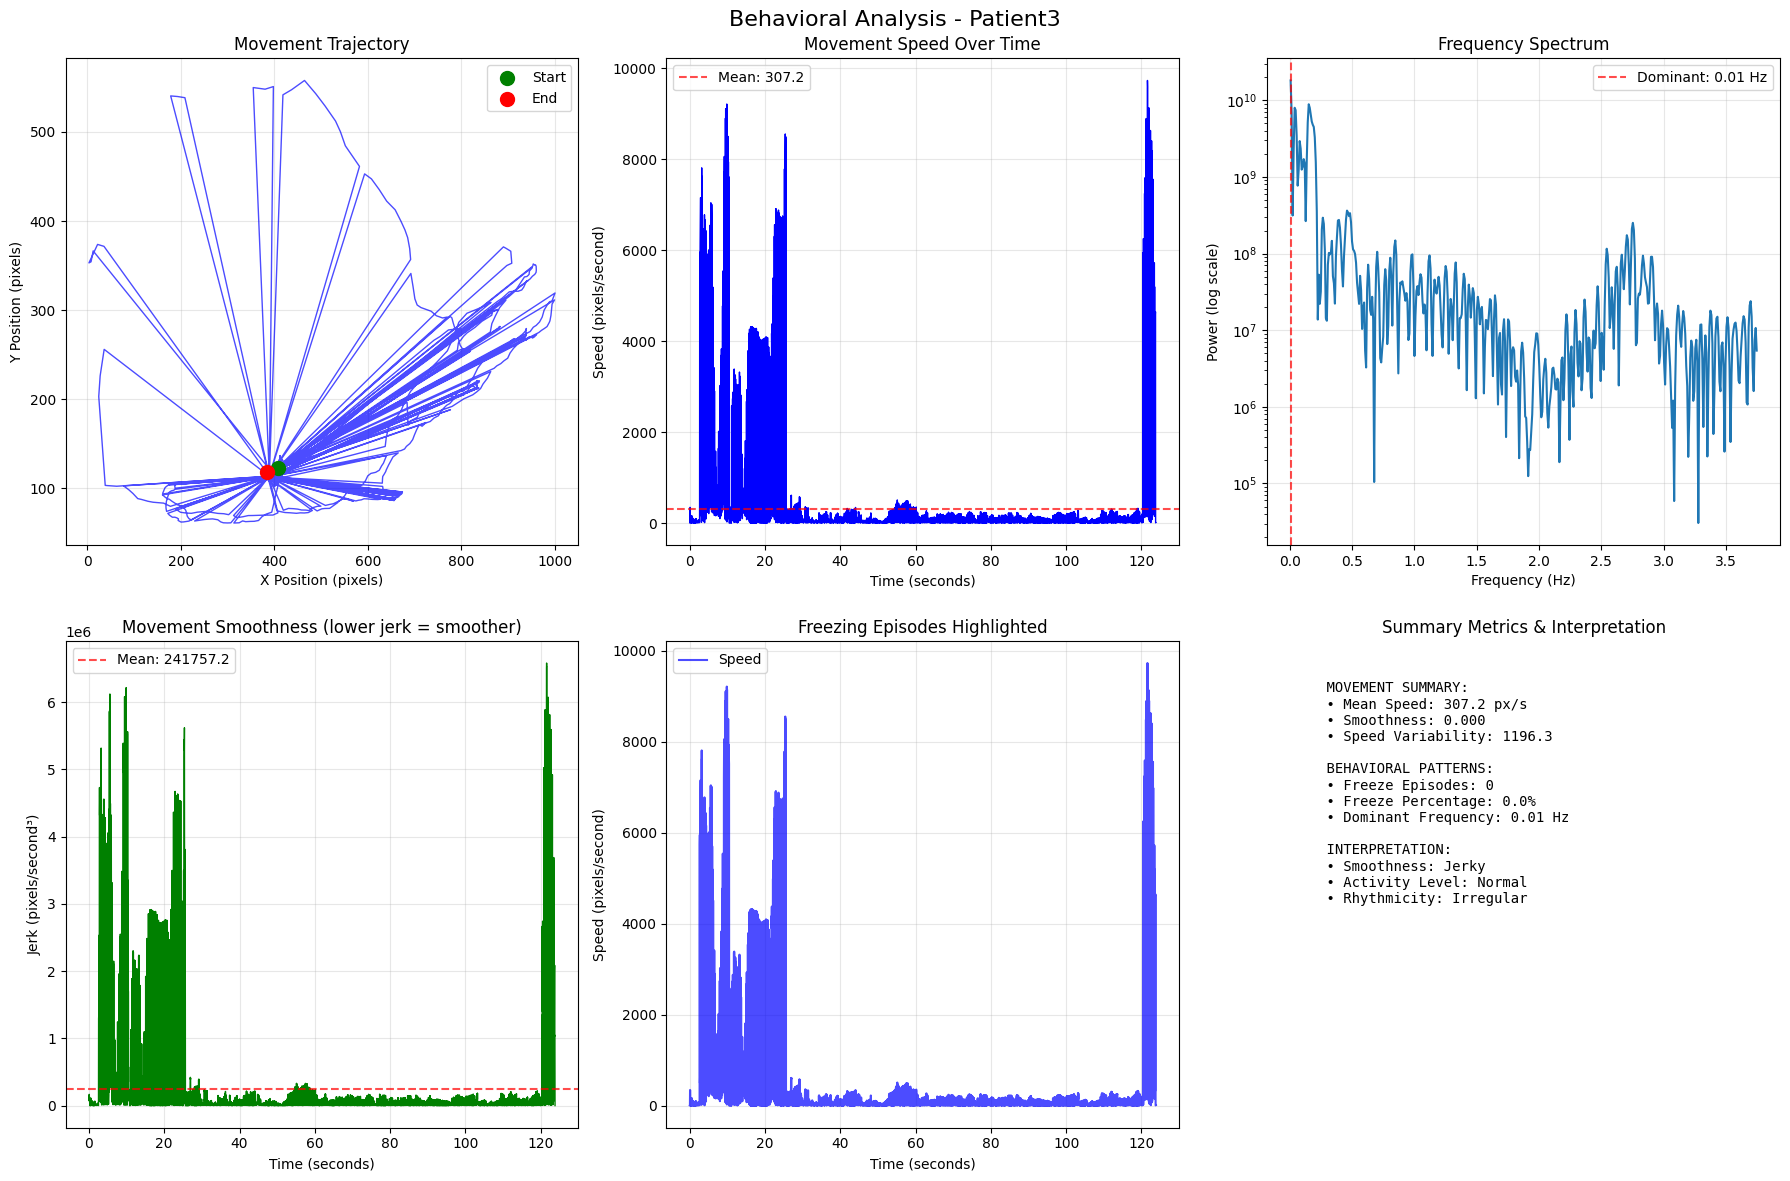

In [20]:
step7_create_visualizations(x, y, movement, freezing, frequency, 'Patient3')

🎯 STARTING COMPLETE BEHAVIORAL ANALYSIS
Patient: Patient2, Joint: Nose, FPS: 30
📊 STEP 1: Extracting data for Patient2 - Nose
   ✅ Found 3716 data points
   ✅ Frame range: 0 to 11774 (span: 11774)
   ✅ X range: 3.97 to 1000.27
   ✅ Y range: 60.93 to 557.86

🔢 STEP 2: Calculating basic movement metrics
   ✅ Mean speed: 307.20 pixels/second
   ✅ Max speed: 9732.23 pixels/second
   ✅ Speed variability (std): 1196.31
   ✅ Smoothness score: 0.000 (higher = smoother)

🧊 STEP 4: Detecting freezing episodes
   Stillness threshold: 10th percentile
   Minimum freeze duration: 1.0 seconds
   Stillness threshold: 0.06 pixels per frame
   ✅ Found 0 freezing episodes
   ✅ Total freeze time: 0.0 seconds
   ✅ Freeze percentage: 0.0% of total time
   ✅ LOW freeze percentage - active movement pattern

📊 STEP 5: Analyzing frequency patterns (rhythmic behaviors)
   ✅ Dominant frequency: 0.01 Hz
   ✅ Spectral entropy: 0.550 (lower = more rhythmic)
   ✅ VERY LOW frequency - minimal rhythmic patterns

🗺️  ST

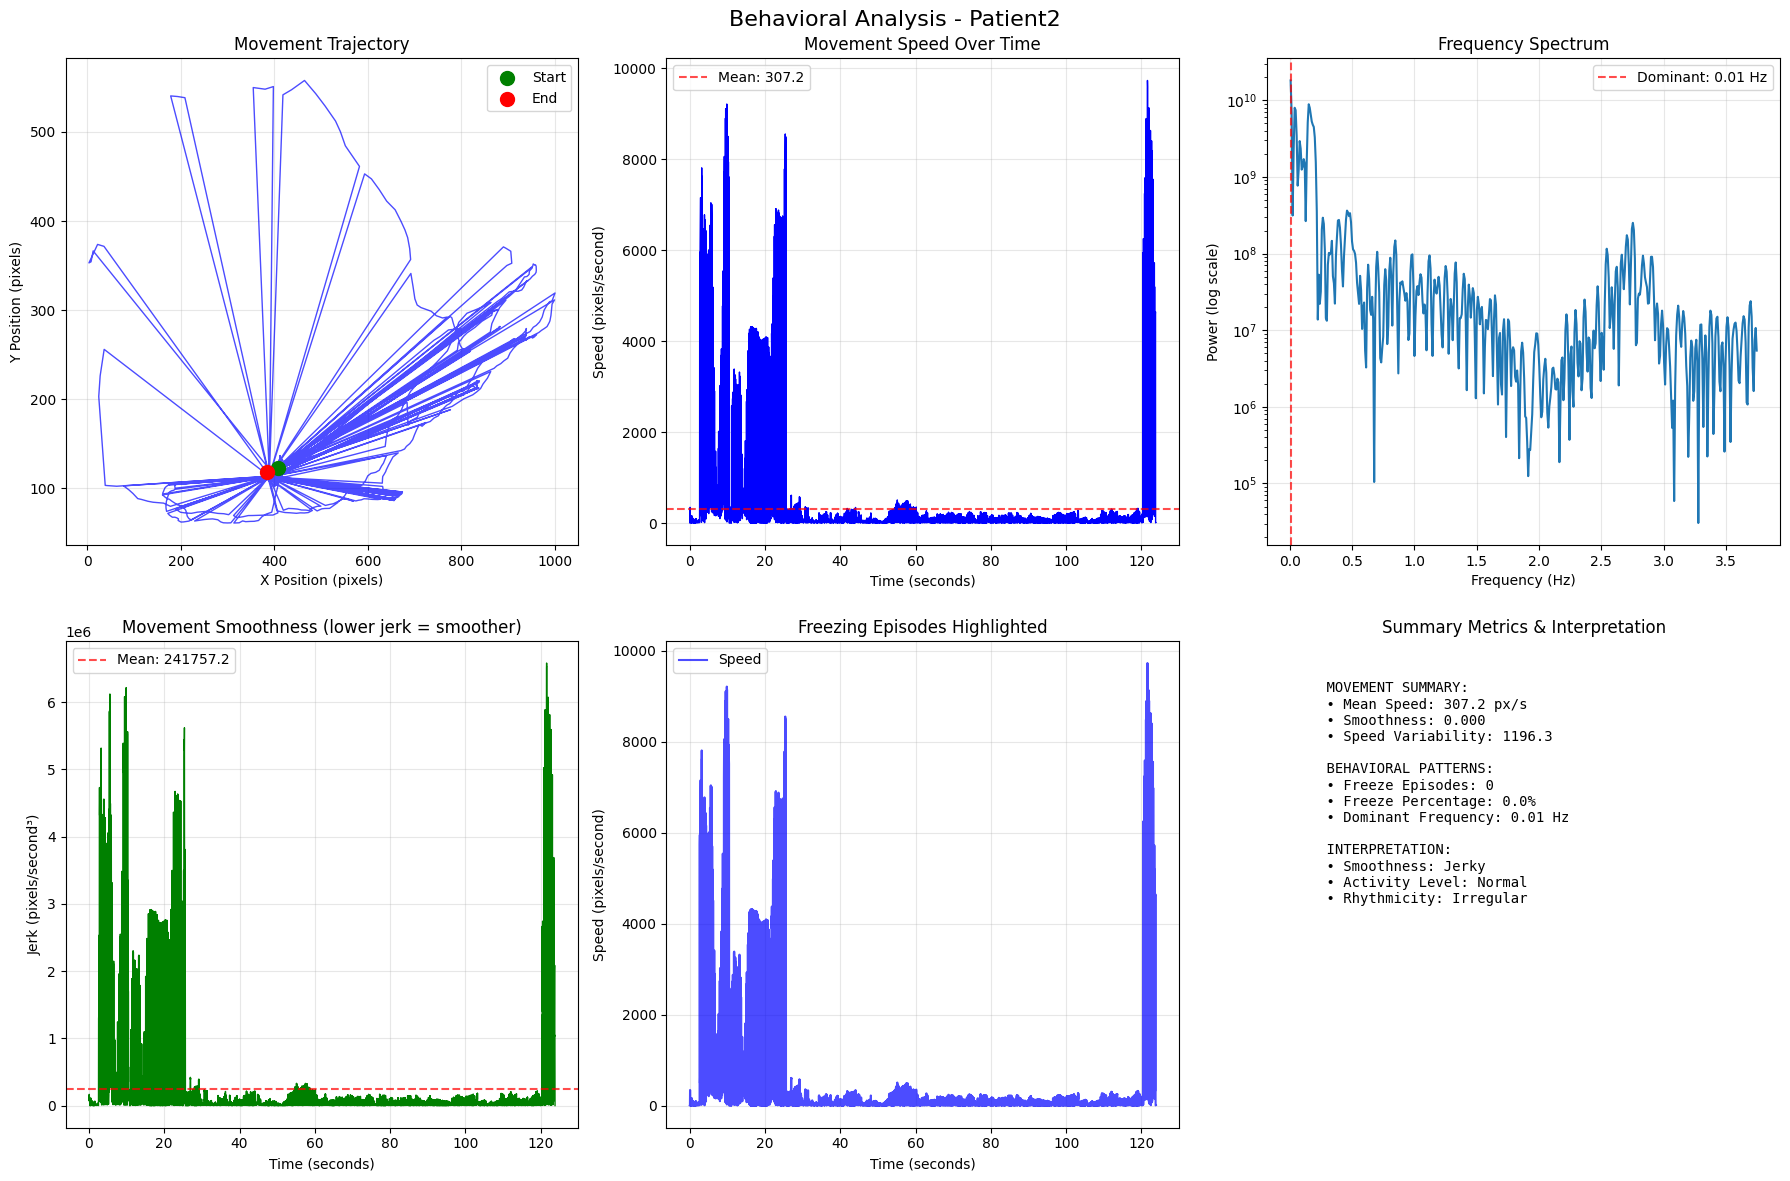


✅ ANALYSIS COMPLETE!
📊 Results stored for Patient2
🎯 STARTING COMPLETE BEHAVIORAL ANALYSIS
Patient: Patient3, Joint: Nose, FPS: 30
📊 STEP 1: Extracting data for Patient3 - Nose
   ✅ Found 4036 data points
   ✅ Frame range: 5 to 11784 (span: 11779)
   ✅ X range: 390.82 to 1026.78
   ✅ Y range: 75.15 to 399.86

🔢 STEP 2: Calculating basic movement metrics
   ✅ Mean speed: 72.67 pixels/second
   ✅ Max speed: 8980.63 pixels/second
   ✅ Speed variability (std): 291.43
   ✅ Smoothness score: 0.000 (higher = smoother)

🧊 STEP 4: Detecting freezing episodes
   Stillness threshold: 10th percentile
   Minimum freeze duration: 1.0 seconds
   Stillness threshold: 0.05 pixels per frame
   ✅ Found 0 freezing episodes
   ✅ Total freeze time: 0.0 seconds
   ✅ Freeze percentage: 0.0% of total time
   ✅ LOW freeze percentage - active movement pattern

📊 STEP 5: Analyzing frequency patterns (rhythmic behaviors)
   ✅ Dominant frequency: 0.01 Hz
   ✅ Spectral entropy: 0.267 (lower = more rhythmic)
   ✅ VE

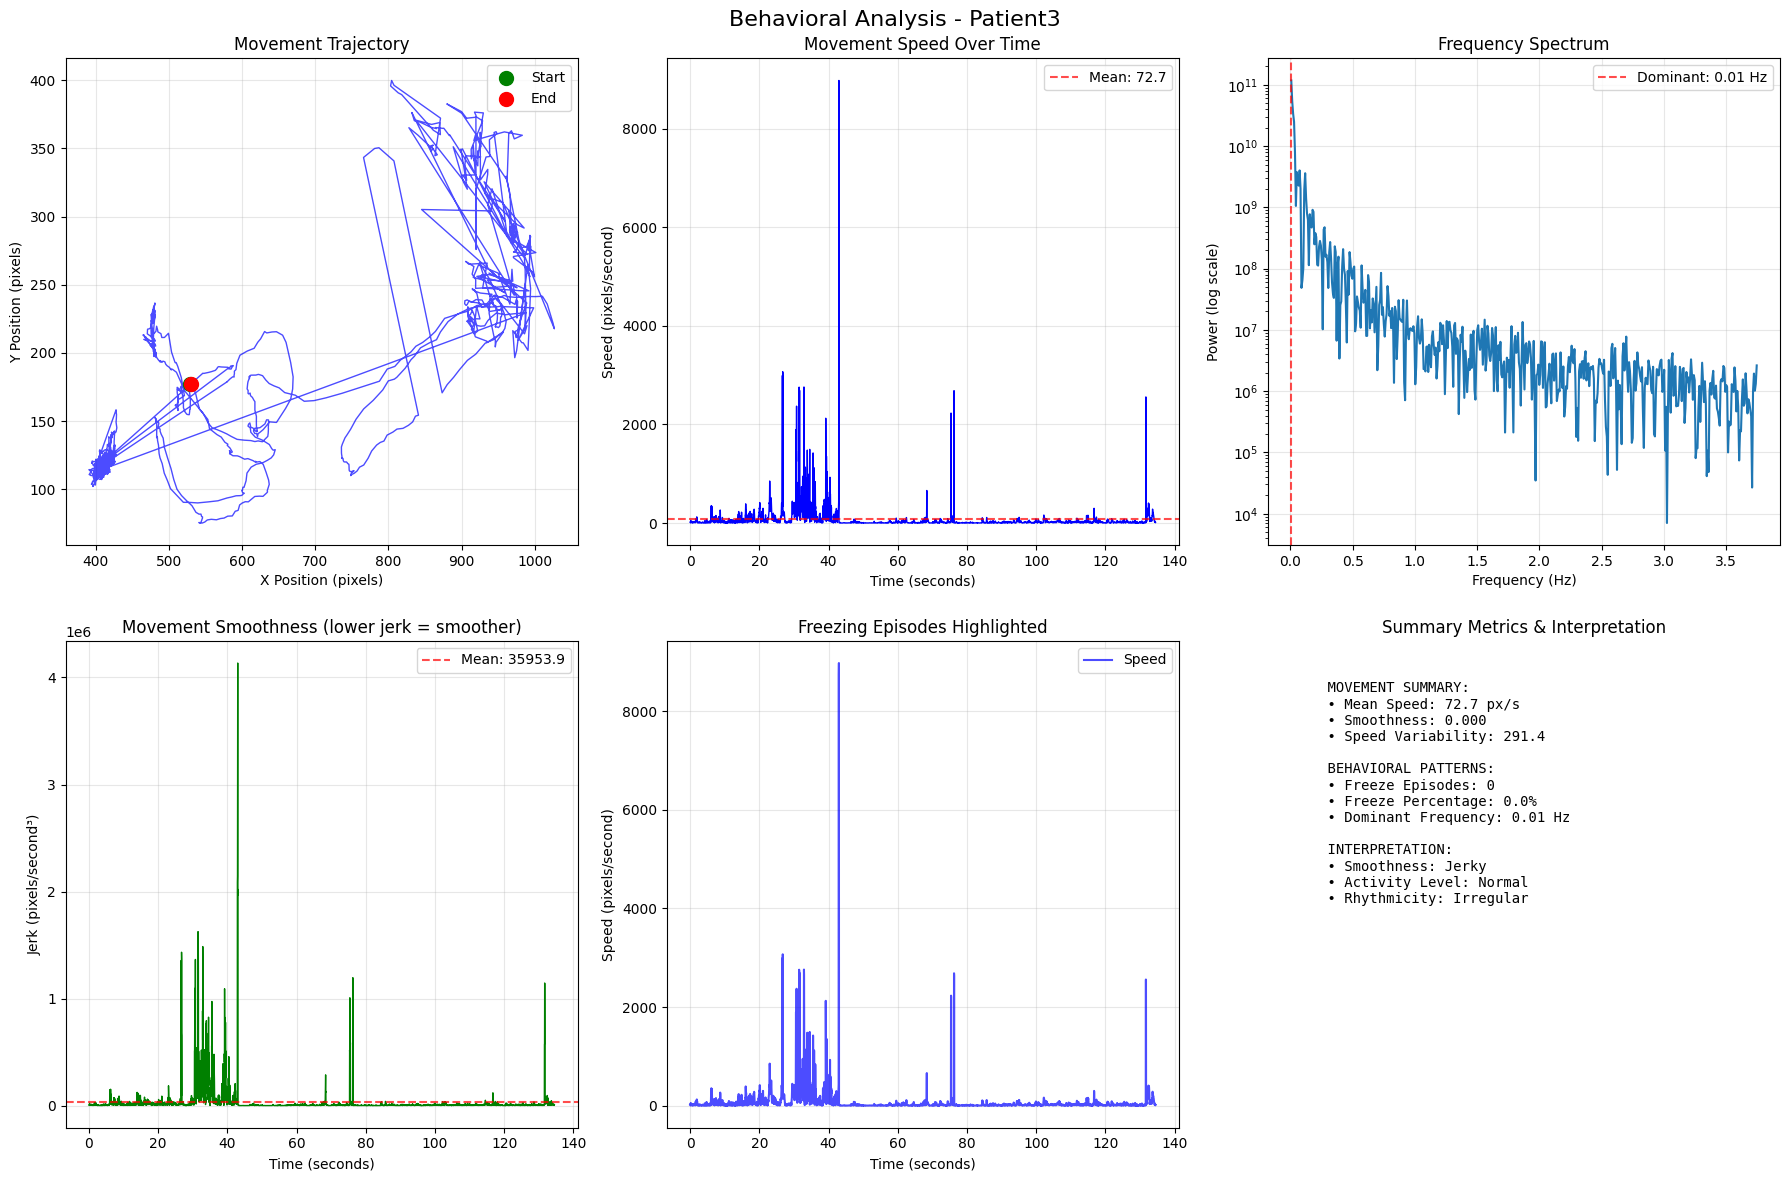


✅ ANALYSIS COMPLETE!
📊 Results stored for Patient3
🎯 STARTING COMPLETE BEHAVIORAL ANALYSIS
Patient: Patient1, Joint: Nose, FPS: 30
📊 STEP 1: Extracting data for Patient1 - Nose
   ✅ Found 4935 data points
   ✅ Frame range: 5 to 11784 (span: 11779)
   ✅ X range: -73.33 to 1063.96
   ✅ Y range: 8.37 to 574.03

🔢 STEP 2: Calculating basic movement metrics
   ✅ Mean speed: 101.35 pixels/second
   ✅ Max speed: 12745.42 pixels/second
   ✅ Speed variability (std): 613.65
   ✅ Smoothness score: 0.000 (higher = smoother)

🧊 STEP 4: Detecting freezing episodes
   Stillness threshold: 10th percentile
   Minimum freeze duration: 1.0 seconds
   Stillness threshold: 0.06 pixels per frame
   ✅ Found 0 freezing episodes
   ✅ Total freeze time: 0.0 seconds
   ✅ Freeze percentage: 0.0% of total time
   ✅ LOW freeze percentage - active movement pattern

📊 STEP 5: Analyzing frequency patterns (rhythmic behaviors)
   ✅ Dominant frequency: 0.01 Hz
   ✅ Spectral entropy: 0.430 (lower = more rhythmic)
   ✅ V

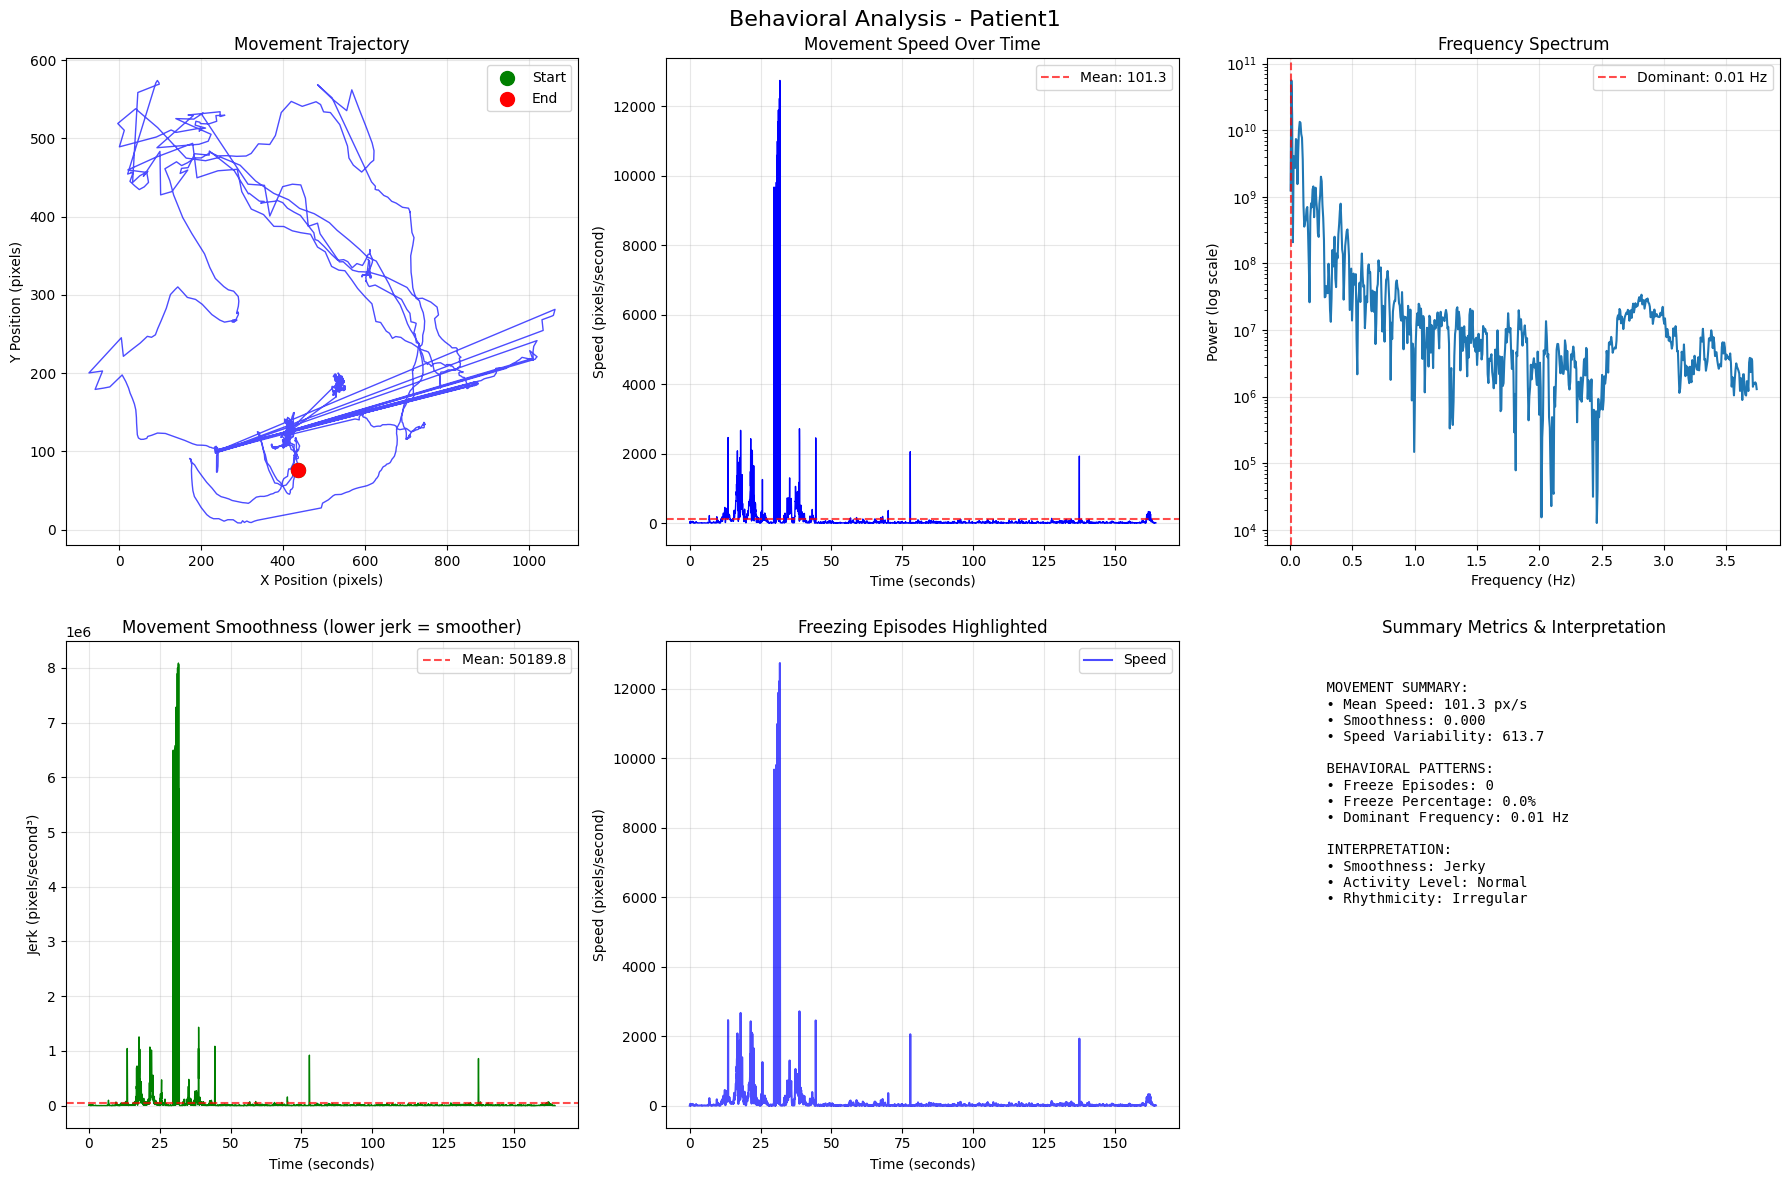


✅ ANALYSIS COMPLETE!
📊 Results stored for Patient1


In [34]:
patients = ['Patient2', 'Patient3', 'Patient1']
all_results = {}
for patient in patients:
    all_results[patient] = run_complete_analysis(df, patient, 'Nose', fps=30)

🎯 STARTING COMPLETE BEHAVIORAL ANALYSIS
Patient: Patient2, Joint: RWrist, FPS: 30
📊 STEP 1: Extracting data for Patient2 - RWrist
   ✅ Found 3716 data points
   ✅ Frame range: 0 to 11774 (span: 11774)
   ✅ X range: 11.48 to 1006.28
   ✅ Y range: 57.02 to 547.64

🔢 STEP 2: Calculating basic movement metrics
   ✅ Mean speed: 312.03 pixels/second
   ✅ Max speed: 9871.79 pixels/second
   ✅ Speed variability (std): 1211.17
   ✅ Smoothness score: 0.000 (higher = smoother)

🧊 STEP 4: Detecting freezing episodes
   Stillness threshold: 10th percentile
   Minimum freeze duration: 1.0 seconds
   Stillness threshold: 0.06 pixels per frame
   ✅ Found 0 freezing episodes
   ✅ Total freeze time: 0.0 seconds
   ✅ Freeze percentage: 0.0% of total time
   ✅ LOW freeze percentage - active movement pattern

📊 STEP 5: Analyzing frequency patterns (rhythmic behaviors)
   ✅ Dominant frequency: 0.01 Hz
   ✅ Spectral entropy: 0.550 (lower = more rhythmic)
   ✅ VERY LOW frequency - minimal rhythmic patterns

🗺

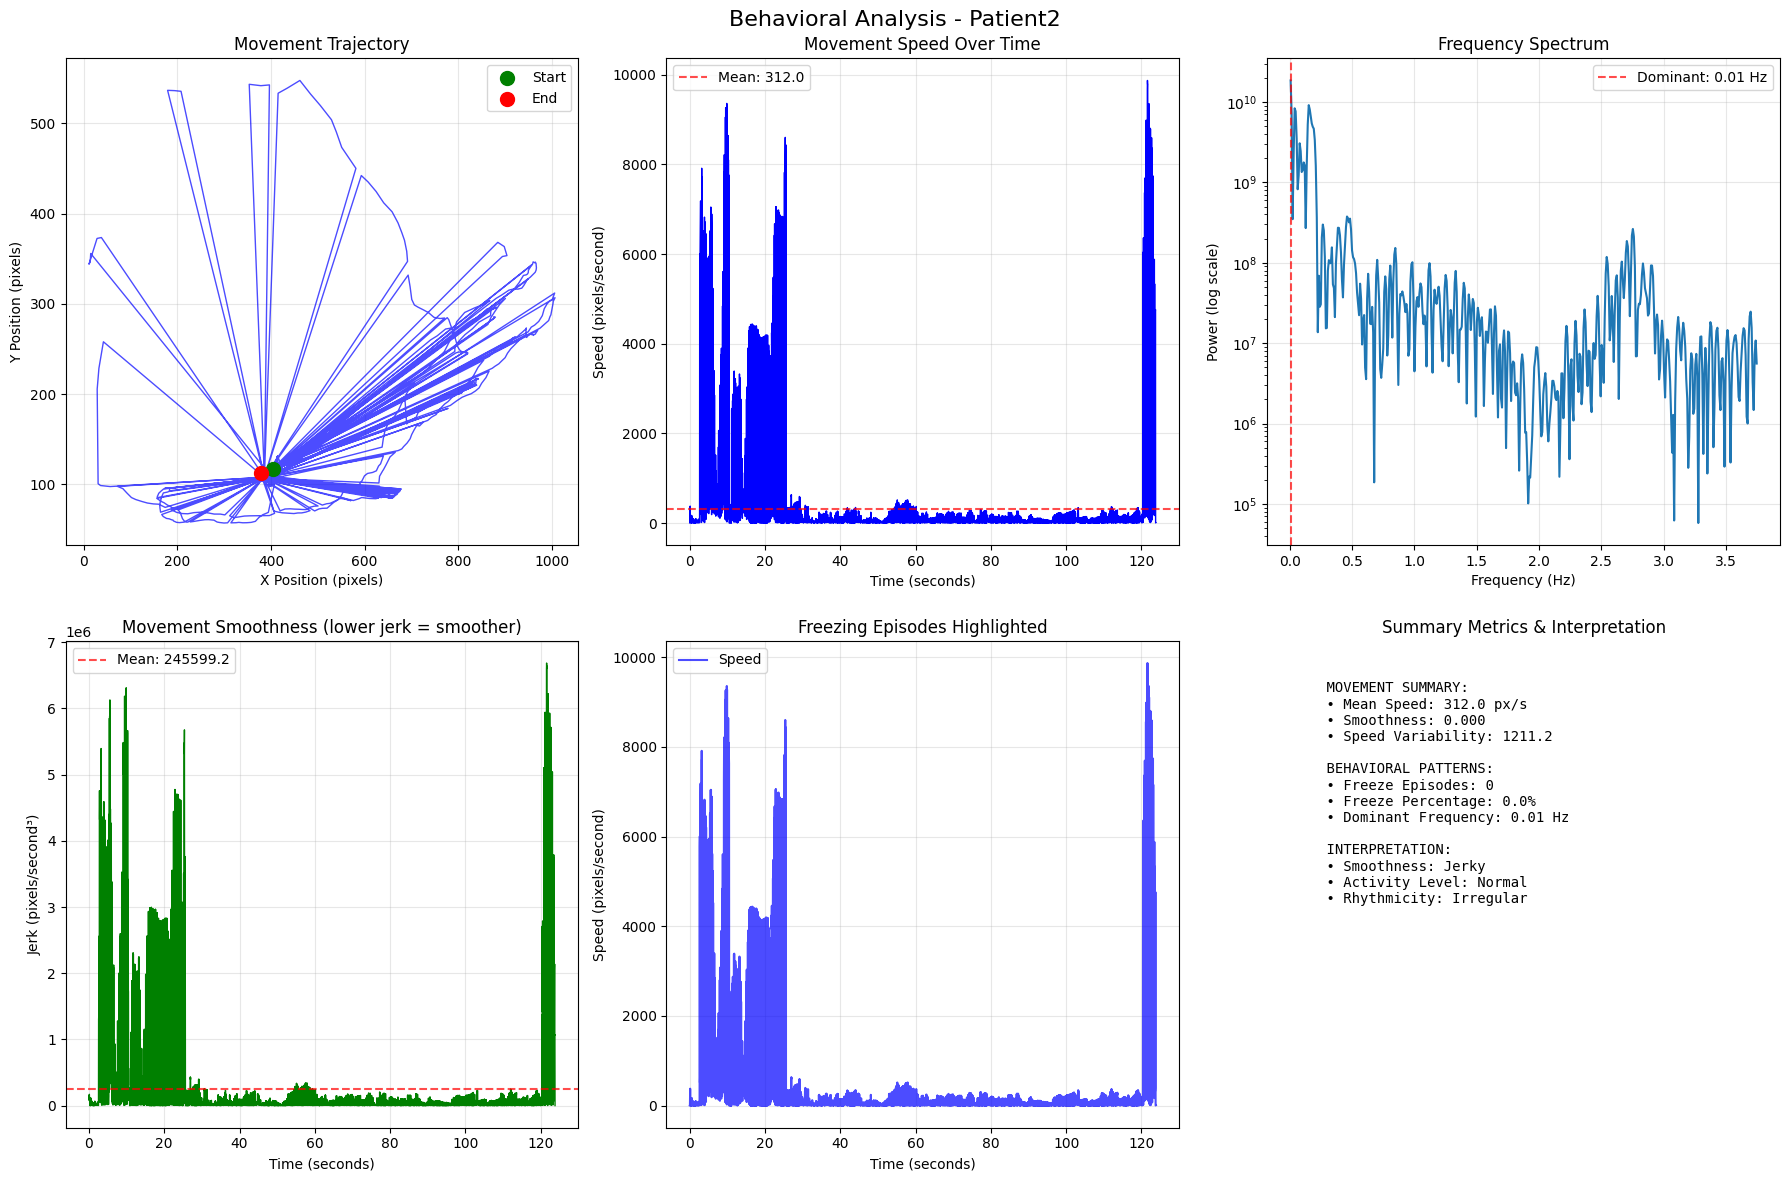


✅ ANALYSIS COMPLETE!
📊 Results stored for Patient2


In [33]:
results = run_complete_analysis(df, 'Patient2', 'RWrist', fps=30)

In [50]:
df['Joint'].unique()

array(['Nose', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder',
       'LElbow', 'LWrist', 'MidHip', 'RHip', 'RKnee', 'RAnkle', 'LHip',
       'LKnee', 'LAnkle', 'REye', 'LEye', 'REar', 'LEar', 'LBigToe',
       'LSmallToe', 'LHeel', 'RBigToe', 'RSmallToe', 'RHeel',
       'Background'], dtype=object)

In [45]:
import matplotlib.pyplot as plt

patient = 'Patient1'
joint = 'Nose'

df_filtered = df[(df['Patient'] == patient) & 
                          (df['Joint'] == joint)]

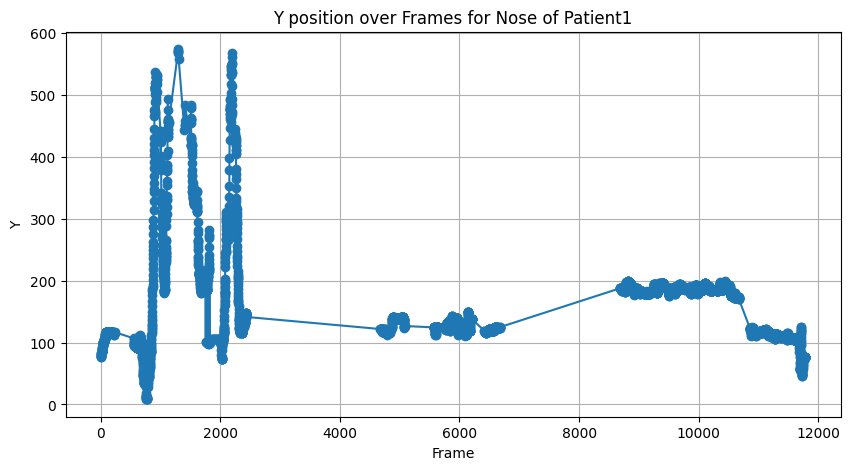

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(df_filtered['Frame'], df_filtered['Y'], marker='o', linestyle='-')
plt.title(f'Y position over Frames for {joint} of {patient}')
plt.xlabel('Frame')
plt.ylabel('Y')
plt.grid(True)
plt.show()

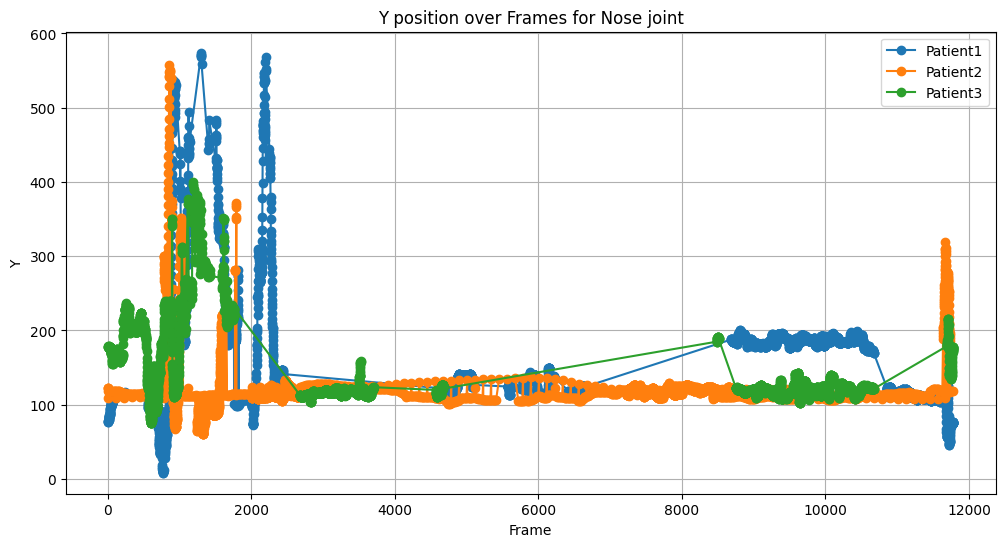

In [52]:
patients = ['Patient1', 'Patient2', 'Patient3']
joint = 'Nose'

plt.figure(figsize=(12, 6))

for patient in patients:
    df_all_filtered = df[(df['Patient'] == patient) & 
                              (df['Joint'] == joint)]
    
    plt.plot(df_all_filtered['Frame'], df_all_filtered['Y'], marker='o', linestyle='-', label=patient)

plt.title(f'Y position over Frames for {joint} joint')
plt.xlabel('Frame')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()